In [48]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sys
from copy import deepcopy

In [49]:
clustering = pd.read_csv('clustering.csv',header=None)
shape = pd.read_csv('ShapedData.csv',header=None)

data_1=np.array(clustering)
data_2=np.array(shape)

### 1. Distance Function

In [50]:
def dist(a,b): #ord_norm: none,1,'fro'
    return np.linalg.norm(a - b)

In [51]:
#create function to calculate Manhattan distance 
def manhattan(a, b):
    return sum(abs(val1-val2) for val1, val2 in zip(a,b))

In [11]:

"""
#define vectors
A = [2, 4, 4, 6]
B = [5, 5, 7, 8]

print(data_1[0], data_1[1])

#calculate Manhattan distance between vectors
manhattan(data_1[0], data_1[1])
"""


[ 0.17978 -1.0343 ] [-0.79447 -0.36758]


1.64097

### 2. Initial Center

In [93]:
def InitialKCenters(X,K):
    
    Y=[] #list for storing centers
    first_c_position= np.random.randint(X.shape[0]) # randomly select a position within obersavation
    Y.append(X[first_c_position]) # add the randomly selected observation to center list
    label = np.zeros(len(X)) # index matrix
    phi = np.zeros(len(X))
    
    """
    search for another (k-1) centers from observation
    """
    for i in range(K-1):
        
        distance=[]
        #phi=0
        
        """
        1. find the nearest center for each observation
        2. calculate d(xi,cj)
        """
        for i in range(len(X)): # for each observation
            min=9999
            for j in range(len(Y)): # compare distance with each center
                d = dist(X[i], Y[j])
                if d < min:
                    min=d
                    #phi[i] = distances # store the distance to the closest center for each observation
                    #index[i] = j
            distance.append(min)  # store the distance to the closest center for each observation (by order)
        
        """
        select the observation with the biggest distance as the next center
        """
        max_dist = max(distance)
        for n in range(len(distance)):
            if distance[n]==max_dist:
                next_c_position = n
        Y.append(X[next_c_position])
        
        distance=[]
        
    """   
    Y_array=np.array(Y)
    plt.scatter(data_1[:, 0], data_1[:, 1], c='b')
    plt.scatter(Y1[:, 0], Y1[:, 1], marker='*', s=150, c='k')
    plt.title('Initial K-centers (k=%d)'%(len(Y)))
    plt.show()
    """
    
    """
    Grouping
    """
    for i in range(len(X)): # for each observation
        min_val=9999
        for j in range(0,K): # compare distance with each center
            distances = dist(X[i], Y[j])
            if distances < min_val:
                min_val=distances
                phi[i] = min_val # store the distance to the closest center for each observation
                label[i] = j
    obj=max(phi)
    #max_dist
    
    #return Y, label, obj
    
    return Y, label

### 3. Cost Function: D

In [71]:
# Cost matrix: cost function for calculating the distance from all data points to each centers

def all_cost(X,Q): # X:data, Q:medians
    
    N,d = X.shape
    n_k = np.array(Q).shape[0]
    
    D = np.zeros((N,n_k))
    
    for i in range (X.shape[0]):
        for j in range (len(Q)):
            cost= dist(X[i],Q[j])
            D[i][j]=cost
        
    return D

In [126]:
"""
W=all_cost(data_1,first_Q)
W
W[-2][1]
"""

array([[4.31755965, 2.76038367],
       [4.99264059, 2.78715616],
       [5.50320072, 3.07281258],
       ...,
       [3.42387839, 6.22891914],
       [0.38308425, 3.18976709],
       [3.08340194, 3.7604104 ]])

### 4. Label Function

In [145]:
# Assign Label

def Label(D): # input: the output of cost function
    
    N,kk = D.shape
    labels=np.zeros(N)
    obj_cost=[] #
    
    for i in range (N):
        min=999
        for j in range (kk):
            c= D[i][j]
            if c < min:
                min = c
            #labels[i] = j
                labels[i] = j
        obj_cost.append(min) #
        
    sum_cost= sum(obj_cost) #
        
    return labels, sum_cost

### 5. Single Swap 

In [148]:
#DEBUGGGGGG

# single swap: find the new medians for each cluster base on the cost matrix
def single_swap_debug(X,Q,tau): 
    
    """
    Assign each data point to the new cluster 
    - calculating the cost(distance) for <all observations> 
    - reassign labels
    """
    D = all_cost(X,Q)
    label,sum_cost = Label(D) #
    
    new_Q = Q
    
    for i in range(len(Q)):
        # collect data points in cluster(i) as a new list
        cluster_data_0 = np.array([X[j] for j in range (len(label)) if label[j]==i])
        
        # calculate the cost matrix for each cluster (median)
        cluster_cost = all_cost(cluster_data_0,Q[i])
        cost_Qi = np.sum(cluster_cost) 
            
    
        """
        Calculate the new cost:
        by assigning each data points in cluster (i) other than median (i) as the new median
        """
        for a in cluster_data_0: # grab each data points in cluster (i) by iteration
            new_Qi = a
            new_cluster_cost = all_cost(cluster_data_0,a) ## ??? how to exclude [a] in [cluster_data]
            new_cost_Qi = np.sum(new_cluster_cost)
            
            """
            Compare new cost with the old one:
            if it reduce by (1-tau), update median(i)
            """
            if new_cost_Qi <= (1-tau)*cost_Qi :
                cost_Qi =  new_cost_Qi
                
                new_Q[i] = a # update median(i)
            
            #else:
            #    new_Q[i] = Q[i]
    
    new_D = all_cost(X,new_Q)
    new_label, new_sum_cost = Label(new_D) #
    
    return new_Q, new_label, new_sum_cost

## 6. Check optimum

In [155]:
# check if medians moved after single_swap

def convg_optimal(Q,new_Q):
    
    #use set() to hash the tuple and sort it
    Q_val = set([tuple(c) for c in Q]) 
    new_Q_val = set([tuple(c) for c in new_Q])
    
    """
    True: medians does not move after swaps
    False: medians moved
    """
    return Q_val == new_Q_val

# * Wrap up

In [191]:
def Kcenter_improve_by_Kmedians_Single_Swap(X,K,tau,max_same): #debug (test which swap is correct)
    
    colors = ['r', 'g', 'b','y', 'c', 'm','orange','purple']
    
    """
    Generate the initial k-centers
    """
    first_Q,first_label = InitialKCenters(X,K)
    
    
    for f in range (K):
        data=np.array([X[i] for i in range (len(first_label)) if first_label[i]==f])
        plt.scatter(data[:, 0], data[:, 1],s=5, c=colors[f])
        plt.scatter(np.array(first_Q)[:, 0], np.array(first_Q)[:, 1], marker='*', s=150, c='k')
        plt.title('Kcenter (k=%d)'%(len(first_Q)))
        #plt.savefig('K-centers (k=%d, iteration :25)'%(len(Y)))
    plt.show()
    
    new_Q = first_Q.copy()
    
    Stop = False
    i=0
    
    #colors = ['r', 'g', 'b','y', 'c', 'm','orange','purple']
    
    # Stop swapping if the medians did not move for [max_same] iterations
    while (not Stop) and (i <= max_same):
        
        Q = new_Q.copy()
        
        """
        Perform single swap heuristic
        """
        new_Q, new_label, new_sum_cost = single_swap_debug(X,new_Q,tau)
        

        """
        True: medians does not move after swaps
        False: medians moved
        """
        Stop = convg_optimal(Q,new_Q)
        
        i+=1 # count how many times does medians remain the same
        
    
    
    
    for z in range (K):
        data=np.array([X[i] for i in range (len(new_label)) if new_label[i]==z])
        plt.scatter(data[:, 0], data[:, 1],s=5, c=colors[z])
        plt.scatter(np.array(new_Q)[:, 0], np.array(new_Q)[:, 1], marker='*', s=150, c='k')
        plt.title('Kcenter_improve_by_Kmedians_Single_Swap (k=%d)'%(len(new_Q)))
        #plt.savefig('K-centers (k=%d, iteration :25)'%(len(Y)))
    plt.show()
    
    
    
    
    return new_Q, new_label, new_sum_cost, first_Q, first_label

    
    

## 1. Data- Clustering

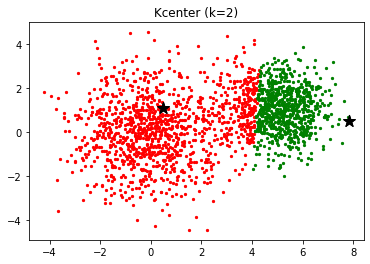

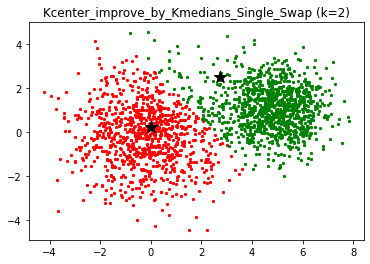

K=2

 -first_Q: 
 [array([0.48756, 1.0812 ]), array([7.8132 , 0.51561])] 

-final_Q: 
 [array([0.010661, 0.20867 ]), array([2.7224, 2.494 ])] 

-first_label: [0. 0. 0. ... 1. 1. 0.] 

-final_label: 
 [0. 0. 0. ... 1. 1. 1.] 

-final_sum_cost:  4562.724811289025


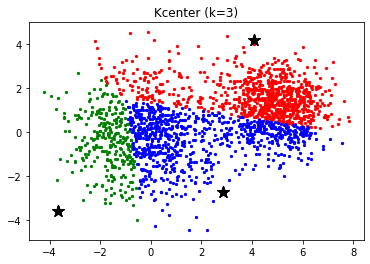

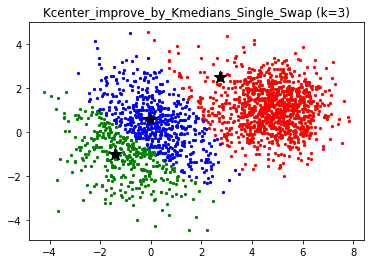

K=3

 -first_Q: 
 [array([4.0893, 4.1636]), array([-3.6773, -3.5965]), array([ 2.8703, -2.7345])] 

-final_Q: 
 [array([2.7224, 2.494 ]), array([-1.3997, -1.0187]), array([-0.027022,  0.60813 ])] 

-first_label: [2. 1. 1. ... 0. 0. 0.] 

-final_label: 
 [1. 1. 1. ... 0. 0. 0.] 

-final_sum_cost:  4284.13743012983


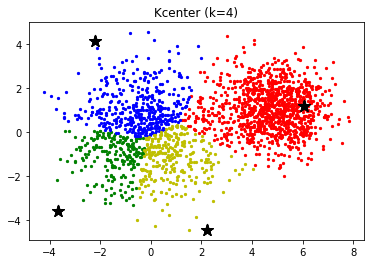

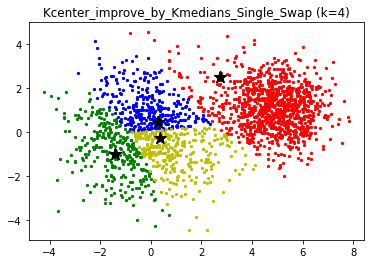

K=4

 -first_Q: 
 [array([6.0475, 1.1613]), array([-3.6773, -3.5965]), array([-2.1987,  4.1088]), array([ 2.2232, -4.4286])] 

-final_Q: 
 [array([2.7224, 2.494 ]), array([-1.3997, -1.0187]), array([0.29475, 0.46672]), array([ 0.35374, -0.25962])] 

-first_label: [3. 1. 2. ... 0. 0. 0.] 

-final_label: 
 [3. 1. 1. ... 0. 0. 0.] 

-final_sum_cost:  4134.3425424863935


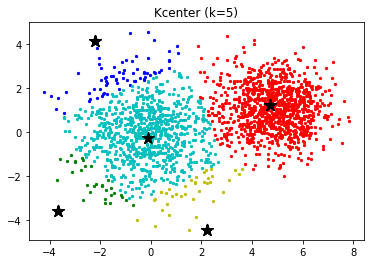

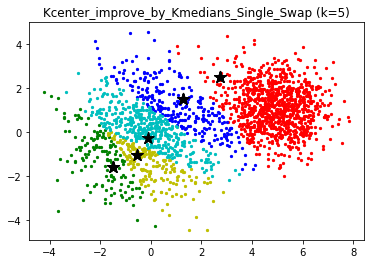

K=5

 -first_Q: 
 [array([4.7207, 1.2313]), array([-3.6773, -3.5965]), array([-2.1987,  4.1088]), array([ 2.2232, -4.4286]), array([-0.12982, -0.25562])] 

-final_Q: 
 [array([2.7224, 2.494 ]), array([-1.4802, -1.5797]), array([1.2748, 1.4996]), array([-0.54999, -1.0504 ]), array([-0.12982, -0.25562])] 

-first_label: [4. 4. 4. ... 0. 0. 0.] 

-final_label: 
 [3. 4. 4. ... 0. 0. 0.] 

-final_sum_cost:  4134.347652841512


 store_D:  [4562.724811289025, 4284.13743012983, 4134.3425424863935, 4134.347652841512]


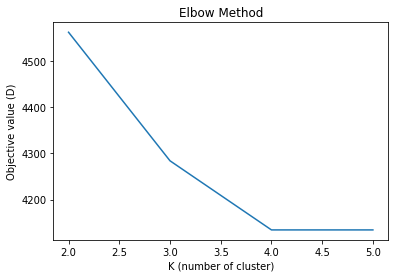

In [193]:
#Formal Anlysis

store_D1=[]
for k in range(2,6):
    new_Q, new_label,new_sum_cost,first_Q,first_label=Kcenter_improve_by_Kmedians_Single_Swap(data_1,k,0.05,2)
    #print("Y: ",Y, "\n\nC: ",C, "\n\nD: ",D)
    print("K=%d\n\n"%(k),"-first_Q: \n",first_Q,"\n\n-final_Q: \n",new_Q,"\n\n-first_label:",first_label,"\n\n-final_label: \n",new_label,"\n\n-final_sum_cost: ",new_sum_cost)
    store_D1.append(new_sum_cost)
print("\n\n store_D: ",store_D1)

x=[2,3,4,5]
plt.xlabel('K (number of cluster)')
plt.ylabel('Objective value (D)')
plt.title('Elbow Method') 
plt.plot(x,store_D1)
plt.savefig("Elbow Method (Data: Clustering (swap))")
plt.show()

## 2. Data- Shape

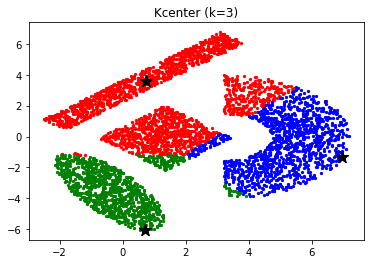

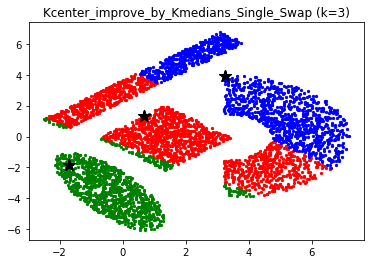

K=3

 -first_Q: 
 [array([0.7508, 3.6276]), array([ 0.71578, -6.0515 ]), array([ 6.9442, -1.3564])] 

-final_Q: 
 [array([0.67946, 1.3467 ]), array([-1.6869, -1.8664]), array([3.2516, 3.9068])] 

-first_label: [2. 2. 2. ... 0. 2. 1.] 

-final_label: 
 [0. 0. 0. ... 2. 2. 1.] 

-final_sum_cost:  12042.823908798173


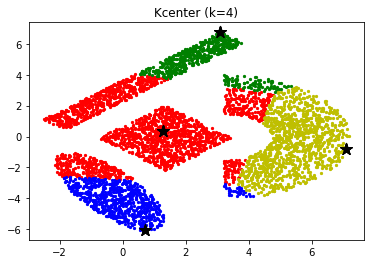

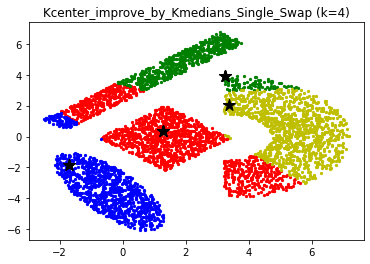

K=4

 -first_Q: 
 [array([1.2688 , 0.35843]), array([3.0811, 6.7565]), array([ 0.71578, -6.0515 ]), array([ 7.0904 , -0.82791])] 

-final_Q: 
 [array([1.2688 , 0.35843]), array([3.2516, 3.9068]), array([-1.6869, -1.8664]), array([3.3859, 2.0386])] 

-first_label: [0. 3. 3. ... 0. 3. 2.] 

-final_label: 
 [0. 3. 0. ... 3. 3. 2.] 

-final_sum_cost:  10110.928244158893


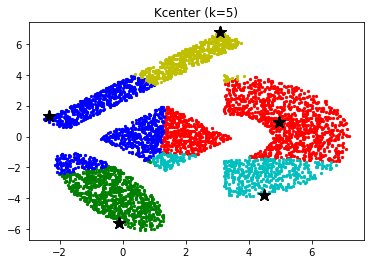

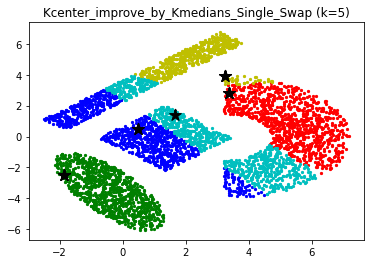

K=5

 -first_Q: 
 [array([4.9501 , 0.94248]), array([-0.11754, -5.6056 ]), array([-2.3275,  1.3119]), array([3.0811, 6.7565]), array([ 4.4835, -3.7653])] 

-final_Q: 
 [array([3.3819, 2.8053]), array([-1.873 , -2.4615]), array([0.4986 , 0.51135]), array([3.2516, 3.9068]), array([1.6525, 1.3728])] 

-first_label: [4. 4. 4. ... 0. 0. 1.] 

-final_label: 
 [2. 4. 4. ... 0. 0. 1.] 

-final_sum_cost:  10297.823504607419


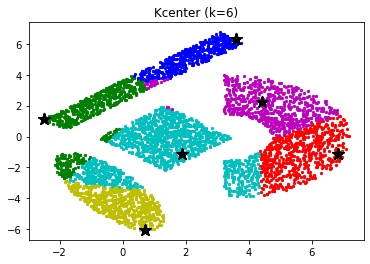

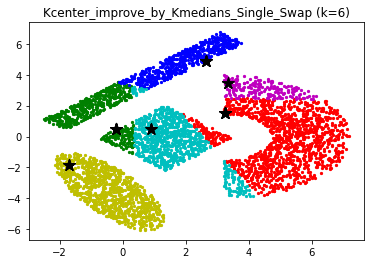

K=6

 -first_Q: 
 [array([ 6.8258, -1.1643]), array([-2.4871,  1.1324]), array([3.5856, 6.3017]), array([ 0.71578, -6.0515 ]), array([ 1.8875, -1.1476]), array([4.4212, 2.2165])] 

-final_Q: 
 [array([3.2603, 1.5487]), array([-0.22167,  0.45759]), array([2.6318, 4.9049]), array([-1.6869, -1.8664]), array([0.91415, 0.48178]), array([3.3415, 3.4841])] 

-first_label: [4. 0. 0. ... 5. 5. 3.] 

-final_label: 
 [4. 0. 0. ... 0. 0. 3.] 

-final_sum_cost:  9176.310240065697


 store_D:  [12042.823908798173, 10110.928244158893, 10297.823504607419, 9176.310240065697]


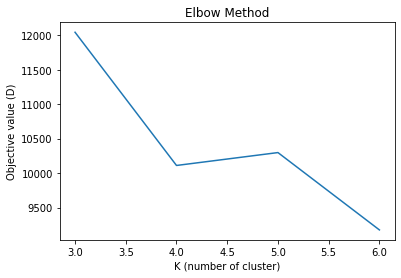

In [194]:
#Formal Anlysis

store_D2=[]
for k in range(3,7):
    new_Q, new_label,new_sum_cost,first_Q,first_label=Kcenter_improve_by_Kmedians_Single_Swap(data_2,k,0.05,2)
    #print("Y: ",Y, "\n\nC: ",C, "\n\nD: ",D)
    print("K=%d\n\n"%(k),"-first_Q: \n",first_Q,"\n\n-final_Q: \n",new_Q,"\n\n-first_label:",first_label,"\n\n-final_label: \n",new_label,"\n\n-final_sum_cost: ",new_sum_cost)
    store_D2.append(new_sum_cost)
print("\n\n store_D: ",store_D2)

x=[3,4,5,6]
plt.xlabel('K (number of cluster)')
plt.ylabel('Objective value (D)')
plt.title('Elbow Method') 
plt.plot(x,store_D2)
plt.savefig("Elbow Method (Data: Shape (swap))")
plt.show()

### Test the whole algorithm (good)

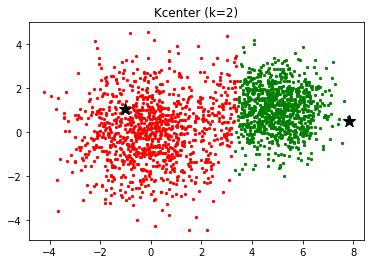

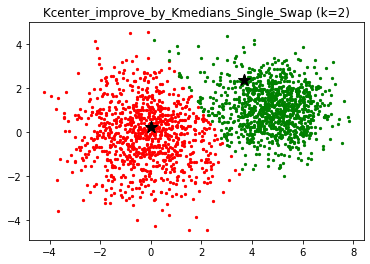

-first_Q: 
 [array([-1.0241,  1.0184]), array([7.8132 , 0.51561])] 

-new_Q: 
 [array([0.010661, 0.20867 ]), array([3.6657, 2.3457])] 

-first_label: [0. 0. 0. ... 1. 1. 1.] 

-new_label: 
 [0. 0. 0. ... 1. 1. 1.] 

-new_sum_cost:  3876.243527114249


In [188]:
"""
Test Clustering (success)
"""
new_Q, new_label, new_sum_cost,first_Q, first_label=Kcenter_improve_by_Kmedians_Single_Swap(data_1,2,0.05,5)
print("-first_Q: \n",first_Q,"\n\n-new_Q: \n",new_Q,"\n\n-first_label:",first_label,"\n\n-new_label: \n",new_label,"\n\n-new_sum_cost: ",new_sum_cost)

"""
new_Q, new_label, new_sum_cost,first_Q, first_label=Kcenter_improve_by_Kmedians_Single_Swap_Debug(data_1,2,0.05,5)
print("-first_Q: \n",first_Q,"\n\n-new_Q: \n",new_Q,"\n\n-first_label:",first_label,"\n\n-new_label: \n",new_label,"\n\n-new_sum_cost: ",new_sum_cost)
"""

In [189]:
first_D = all_cost(data_1,first_Q)
first_median_label, first_sum_cost = Label(first_D)
print(first_sum_cost)

5318.146999420517


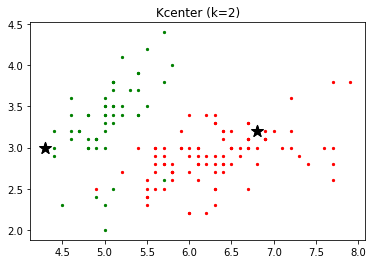

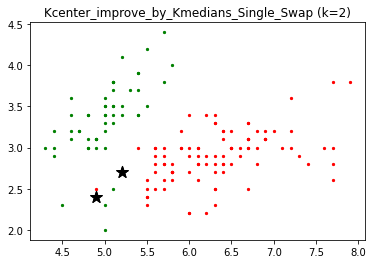

-first_Q: 
 [array([6.8, 3.2, 5.9, 2.3], dtype=object), array([4.3, 3.0, 1.1, 0.1], dtype=object)] 

-new_Q: 
 [array([5.2, 2.7, 3.9, 1.4], dtype=object), array([4.9, 2.4, 3.3, 1.0], dtype=object)] 

-first_label: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] 

-new_label: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0

In [187]:
#TEST IRIS

new_Q, new_label, new_sum_cost,first_Q, first_label=Kcenter_improve_by_Kmedians_Single_Swap_Debug(iris,2,0.05,5)
print("-first_Q: \n",first_Q,"\n\n-new_Q: \n",new_Q,"\n\n-first_label:",first_label,"\n\n-new_label: \n",new_label,"\n\n-new_sum_cost: ",new_sum_cost)

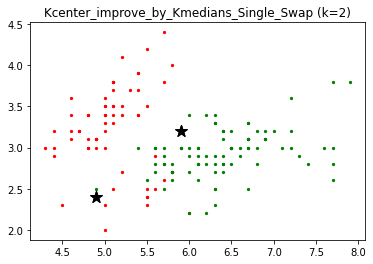

-new_Q:  [array([4.9, 2.4, 3.3, 1.0], dtype=object), array([5.9, 3.2, 4.8, 1.8], dtype=object)] 

-new_label: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.] 

-new_sum_cost:  217.72038292388675 

-first_Q:  [array([5.1, 3.8, 1.9, 0.4], dtype=object), array([7.7, 2.6, 6.9, 2.3], dtype=object)]


In [176]:
"""
first_Q,_ = InitialKCenters(X,K)
print("a: \n",first_Q)

Stop = False
i=0
max_same=5
   
new_Q = first_Q  
    
# Stop swapping if the medians did not move for [max_same] iterations
while (not Stop) and (i <= max_same):
        
    Q = new_Q.copy()
        
    
    #Perform single swap heuristic
    
    new_Q, new_label, new_sum_cost = single_swap_debug(X,first_Q,tau)
        

    
    #True: medians does not move after swaps
    #False: medians moved
    
    Stop = convg_optimal(Q,new_Q)
        
    i+=1
"""


new_Q, new_label, new_sum_cost,first_Q=Kcenter_improve_by_Kmedians_Single_Swap_Debug(iris,2,0.05,5)
print("-new_Q: ",new_Q,"\n\n-new_label: \n",new_label,"\n\n-new_sum_cost: ",new_sum_cost,"\n\n-first_Q: ",first_Q)

In [158]:
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)
iris=np.array(dataset)
iris=iris[:,:-1]

In [161]:
"""
Test IRIS
"""
firstQ,old_label = InitialKCenters(iris,2)
old_label,sum_cost = Label(all_cost(iris,firstQ))
print("first_Q: ",firstQ, "old_label: ", old_label,"cost: ",sum_cost)


#new_Q,label = single_swap(iris,firstQ,0.05)
new_Q,_,_= single_swap_debug(iris,firstQ,0.05)
new_label,sum_cost = Label(all_cost(iris,new_Q))
print("new_Q: ",new_Q, "new_label: ", new_label,"cost: ",sum_cost)

first_Q:  [array([4.5, 2.3, 1.3, 0.3], dtype=object), array([7.7, 2.6, 6.9, 2.3], dtype=object)] old_label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.] cost:  304.51393998917194
new_Q:  [array([4.9, 2.4, 3.3, 1.0], dtype=object), array([5.9, 3.2, 4.8, 1.8], dtype=object)] new_label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 0

In [162]:
"""
Test IRIS
"""
firstQ,old_label = InitialKCenters(iris,2)
old_label,sum_cost = Label(all_cost(iris,firstQ))
print("first_Q: ",firstQ, "old_label: ", old_label,"cost: ",sum_cost)


#new_Q,label = single_swap(iris,firstQ,0.05)
new_Q,_,_= single_swap_debug(iris,firstQ,0.05)
new_label,sum_cost = Label(all_cost(iris,new_Q))
print("new_Q: ",new_Q, "new_label: ", new_label,"cost: ",sum_cost)

first_Q:  [array([6.1, 3.0, 4.9, 1.8], dtype=object), array([4.3, 3.0, 1.1, 0.1], dtype=object)] old_label:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] cost:  155.0995150749793
new_Q:  [array([4.9, 2.5, 4.5, 1.7], dtype=object), array([4.3, 3.0, 1.1, 0.1], dtype=object)] new_label:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

In [154]:
type(firstQ[0])

numpy.ndarray

In [132]:
"""
Test IRIS 2-1
"""

"""
firstQ,old_label = InitialKCenters(iris,2)
print("first_Q: ",firstQ, "\n\nold_label: \n", old_label)

D = all_cost(iris,firstQ)
label = Label(D)
    
new_Q = firstQ
    
for i in range(len(firstQ)):
    # collect data points in cluster(i) as a new list
    cluster_data_0 = np.array([iris[j] for j in range (len(label)) if label[j]==i])
    print("\n\ncluster_data_0: \n",cluster_data_0)
    
    # calculate the cost matrix for each cluster (median)
    cluster_cost = all_cost(cluster_data_0,firstQ[i])
    cost_Qi = np.sum(cluster_cost) 
    
    print("\n\nc_c: ",cluster_cost)
    """

first_Q:  [array([5.0, 3.0, 1.6, 0.2], dtype=object), array([7.7, 2.6, 6.9, 2.3], dtype=object)] 

old_label: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


cluster_data_0: 
 [[5.1 3.5 1.4 0.2]
 [4.9 3.0 1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.0 3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.0 3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.0 1.4 0.1]
 [4.3 3.0 1.1 0.1]
 [5.8 4.0 1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1

In [133]:
"""
Test IRIS 2-2
"""

"""
print(old_label)
D = all_cost(iris,firstQ)
label = Label(D)
print("label: ", label)
for i in range(len(firstQ)):
    cluster_data_0 = np.array([iris[j] for j in range (len(label)) if label[j]==i])
    print("\n\ncluster_data_0: \n",cluster_data_0)
    print(len(cluster_data_0))
    """

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


cluster_data_0: 
 [[5.1 3.5 1.4 0.2]
 [4.9 3.0 1.4 0.2]
 [4.7 3.2 1.3 0.2]

In [83]:
"""
# single swap: find the new medians for each cluster base on the cost matrix
def single_swap(X,Q,tau): 
    
    """
    #Assign each data point to the new cluster 
    #- calculating the cost(distance) for <all observations> 
    #- reassign labels
    """
    D = all_cost(X,Q)
    label = Label(D)
    
    new_Q = Q
    
    for i in range(len(Q)):
        
        # calculate the cost matrix for each cluster
        cluster_cost = all_cost(X,Q[i]) 
        cost_Qi = np.sum(cluster_cost) # recent cost for median(i)
        
        # collect data points in cluster(i) as a new list
        cluster_data = np.array([X[j] for j in range (len(label)) if label[j]==i])
        
        """
        Calculate the new cost:
        by assigning each data points in cluster (i) other than median (i) as the new median
        """
        for a in cluster_data: # grab each data points in cluster (i) by iteration
            new_Qi = a
            new_cluster_cost = all_cost(cluster_data,a) ## ??? how to exclude [a] in [cluster_data]
            new_cost_Qi = np.sum(new_cluster_cost)
            
            """
            Compare new cost with the old one:
            if it reduce by (1-tau), update median(i)
            """
            if new_cost_Qi <= (1-tau)*cost_Qi :
                cost_Qi =  new_cost_Qi
                
                new_Q[i] = a # update median(i)
            
            #else:
            #    new_Q[i] = Q[i]
    
    new_D = all_cost(X,new_Q)
    label = Label(new_D)
    
    return new_Q, label
"""

In [134]:
"""
Test CLUSTERING (success)
"""

firstQ,old_label = InitialKCenters(data_1,2)
print("first_Q: ",firstQ, "old_label: ", old_label)

#new_Q,label = single_swap(iris,firstQ,0.05)
new_Q,_ = single_swap(data_1,firstQ,0.05)
new_label = Label(all_cost(data_1,new_Q))
print("new_Q: ",new_Q, "new_label: ", new_label)

first_Q:  [array([4.4568, 1.0409]), array([-3.6773, -3.5965])] old_label:  [1. 1. 1. ... 0. 0. 0.]
new_Q:  [array([1.2748, 1.4996]), array([-0.82663, -0.84056])] new_label:  [1. 1. 1. ... 0. 0. 0.]


------- 1st centroid 似乎沒被update到 (已解決)-------

In [139]:
"""
Test CLUSTERING 2 Debug
"""

firstQ,old_label = InitialKCenters(data_1,2)
print("first_Q: ",firstQ, "old_label: ", old_label)

#new_Q,label = single_swap(iris,firstQ,0.05)
new_Q,_ = single_swap_debug(data_1,firstQ,0.05)
new_label = Label(all_cost(data_1,new_Q))
print("new_Q: ",new_Q, "new_label: ", new_label)


first_Q:  [array([5.4796, 2.8765]), array([-3.6773, -3.5965])] old_label:  [1. 1. 1. ... 0. 0. 0.]
new_Q:  [array([2.7224, 2.494 ]), array([-0.79447, -0.36758])] new_label:  [1. 1. 1. ... 0. 0. 0.]


In [ ]:
def Kcenter_improve_by_Kmedians_Single_Swap(X,K,tau,max_same):
    
    """
    Generate the initial k-centers
    """
    first_Q,_,_ = InitialKCenters(X,K)

    """
    Perform single swap heuristic
    """
    single_swap(X,first_Q,tau)
    
    

In [ ]:
#testtestestsesset
#def Kcenter_improve_by_Kmedians_Single_Swap(X,K,tau):
    
    """
    Generate the initial k-centers
    """
    old_Q,label,_ =InitialKCenters(X,K)
    
    N,d = X.shape
    
    """label=np.zeros(N)
    obj_cost=[]"""
    
    old_obj=np.zeros(Q.shape)
    
    """
    for i in range (N):
        min=999
        for j in range (len(Q)):
            cost= dist(X[i]-Q[j])
            if cost < min:
                min = cost
        label[i]=j
        obj_cost.append(min)
    """
    
    #Assign data point to each cluster for the initial centers we generate by k-centers alg
    label,obj_cost=label_cost(X,old_Q)
        
    old_obj = deepcopy(obj_cost)
        
    while old_obj > (1-tau)*obj_cost:


In [17]:
"""
# Define cluster label & cost

def label_cost(X,Q):
    
    label=np.zeros(N)
    obj_cost=[]
    
    for i in range (X.shape):
        min=999
        for j in range (len(Q)):
            cost= dist(X[i]-Q[j])
            if cost < min:
                min = cost
        label[i]=j
        obj_cost.append(min)
        
    return label, obj_cost
"""

In [46]:
Q,_,_ =InitialKCenters(data_1,2)
print(np.array(Q).shape[0])
print(data_1.shape)
DD = np.zeros((data_1.shape[0],np.array(Q).shape[0]))
#N,d = data_1.shape
#print(N,d)
print("DD: ",DD.shape)
DD[0][1]=dist(data_1[0], Q[0])
print(DD[0][1])
DD

2
(2000, 2)
DD:  (2000, 2)
2.3034954742738263


array([[0.        , 2.30349547],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [13]:
obj_cost=100
obj_old = deepcopy(obj_cost)
        
print(obj_old > 0.95*obj_cost)

True


In [149]:
labelss=[2,2,1,2,2,3,4]
j=0
for i in set(labelss):
    print(i)
    j+=1
print(j)    

1
2
3
4
4


In [25]:
A=np.array([[1,2,3],[2,3,4]])
B=np.array([2,2,2])
C=np.sum(A)

In [26]:
C

15